In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
import os

# ----------------------------
# Dataset Class
# ----------------------------
class AppleDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, images_dir, transforms=None):
        import json
        import os
        self.transforms = transforms
        self.images_dir = images_dir

        with open(annotations) as f:
            coco = json.load(f)

        self.images = coco["images"]
        self.annotations = coco["annotations"]
        self.categories = coco["categories"]

        # Group annotations by image_id
        self.img_id_to_annots = {}
        for ann in self.annotations:
            self.img_id_to_annots.setdefault(ann["image_id"], []).append(ann)

    def __getitem__(self, idx):
        import os, PIL.Image as Image
        img_info = self.images[idx]
        img_path = os.path.join(self.images_dir, img_info["file_name"])
        img = Image.open(img_path).convert("RGB")

        annots = self.img_id_to_annots.get(img_info["id"], [])

        boxes, labels = [], []
        for ann in annots:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"] + 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_info["id"]])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.images)


# ----------------------------
# Prepare Dataset & DataLoader
# ----------------------------
transform = torchvision.transforms.ToTensor()

train_dataset = AppleDataset("apple-detection/train/_annotations.coco.json", "apple-detection/train", transforms=transform)
val_dataset   = AppleDataset("apple-detection/valid/_annotations.coco.json", "apple-detection/valid", transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


# ----------------------------
# Model Setup
# ----------------------------
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)
num_classes = 5  # background + apple
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)


# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 10
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Save checkpoint each epoch
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth")
    torch.save({
        "epoch": epoch+1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": avg_loss,
    }, checkpoint_path)

    print(f"Saved checkpoint: {checkpoint_path}")

# Save final model
torch.save(model.state_dict(), "fasterrcnn_final.pth")
print("Training complete. Final model saved as fasterrcnn_final.pth")


Using device: cpu


c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
import os
import time
import json
from PIL import Image

# ----------------------------
# Dataset Class
# ----------------------------
class AppleDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, images_dir, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir

        with open(annotations) as f:
            coco = json.load(f)

        self.images = coco["images"]
        self.annotations = coco["annotations"]
        self.categories = coco["categories"]

        # Group annotations by image_id
        self.img_id_to_annots = {}
        for ann in self.annotations:
            self.img_id_to_annots.setdefault(ann["image_id"], []).append(ann)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.images_dir, img_info["file_name"])
        img = Image.open(img_path).convert("RGB")

        annots = self.img_id_to_annots.get(img_info["id"], [])

        boxes, labels = [], []
        for ann in annots:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"] + 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_info["id"]])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.images)


# ----------------------------
# Prepare Dataset & DataLoader
# ----------------------------
transform = torchvision.transforms.ToTensor()

train_dataset = AppleDataset("apple-detection/train/_annotations.coco.json", "apple-detection/train", transforms=transform)
val_dataset = AppleDataset("apple-detection/valid/_annotations.coco.json", "apple-detection/valid", transforms=transform)

# Use full dataset for training
print(f"Training with {len(train_dataset)} images")
print(f"Validation with {len(val_dataset)} images")

train_loader = DataLoader(
    train_dataset,
    batch_size=4,  # Increased batch size for better efficiency
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=2  # Enable parallel data loading
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=2
)

# ----------------------------
# Model Setup
# ----------------------------
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)
num_classes = 5  # background + apple
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

print(f"Model loaded with {num_classes} classes")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 20  # Increased epochs for full dataset
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_loss = float('inf')
train_losses = []
val_losses = []

print(f"Starting training for {num_epochs} epochs...")
print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches per epoch: {len(val_loader)}")

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Training phase
    model.train()
    running_loss = 0.0
    
    for batch_idx, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
        
        # Progress update every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch {batch_idx+1}/{len(train_loader)} - Loss: {losses.item():.4f}")

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Learning rate scheduling
    scheduler.step()
    
    epoch_time = time.time() - start_time
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {epoch_time:.1f}s")
    
    # Save checkpoint each epoch
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth")
    torch.save({
        "epoch": epoch+1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "train_losses": train_losses,
        "val_losses": val_losses
    }, checkpoint_path)
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
        torch.save({
            "epoch": epoch+1,
            "model_state_dict": model.state_dict(),
            "val_loss": avg_val_loss
        }, best_model_path)
        print(f"  New best model saved with validation loss: {avg_val_loss:.4f}")
    
    print(f"  Checkpoint saved: {checkpoint_path}")
    print()

# Save final model
final_model_path = "fasterrcnn_final_full_dataset.pth"
torch.save({
    "model_state_dict": model.state_dict(),
    "final_train_loss": train_losses[-1],
    "final_val_loss": val_losses[-1],
    "train_losses": train_losses,
    "val_losses": val_losses
}, final_model_path)

print("Training complete!")
print(f"Final model saved as: {final_model_path}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")

# Print summary
print(f"\nTraining Summary:")
print(f"Total epochs: {num_epochs}")
print(f"Total training images: {len(train_dataset)}")
print(f"Total validation images: {len(val_dataset)}")
print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches per epoch: {len(val_loader)}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")


Training with 390 images
Validation with 112 images
Using device: cpu


c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded with 5 classes
Total parameters: 41,314,536
Starting training for 20 epochs...
Training batches per epoch: 98
Validation batches per epoch: 28


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
import os
import time
import json
from PIL import Image

# ----------------------------
# Dataset Class
# ----------------------------
class AppleDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, images_dir, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir

        with open(annotations) as f:
            coco = json.load(f)

        self.images = coco["images"]
        self.annotations = coco["annotations"]
        self.categories = coco["categories"]

        # Group annotations by image_id
        self.img_id_to_annots = {}
        for ann in self.annotations:
            self.img_id_to_annots.setdefault(ann["image_id"], []).append(ann)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.images_dir, img_info["file_name"])
        img = Image.open(img_path).convert("RGB")

        annots = self.img_id_to_annots.get(img_info["id"], [])

        boxes, labels = [], []
        for ann in annots:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"] + 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_info["id"]])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.images)


# ----------------------------
# Prepare Dataset & DataLoader
# ----------------------------
transform = torchvision.transforms.ToTensor()

train_dataset = AppleDataset("apple-detection/train/_annotations.coco.json", "apple-detection/train", transforms=transform)
val_dataset = AppleDataset("apple-detection/valid/_annotations.coco.json", "apple-detection/valid", transforms=transform)

# Use 50% of dataset for faster training
total_train_images = len(train_dataset)
half_train_images = total_train_images // 2

# Limit to 50% of training data
train_dataset.images = train_dataset.images[:half_train_images]

print(f"Training with {len(train_dataset)} images (50% of {total_train_images} total)")
print(f"Validation with {len(val_dataset)} images")

train_loader = DataLoader(
    train_dataset,
    batch_size=4,  # Increased batch size for better efficiency
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=2  # Enable parallel data loading
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=2
)

# ----------------------------
# Model Setup
# ----------------------------
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)
num_classes = 5  # background + apple
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

print(f"Model loaded with {num_classes} classes")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 10  # Reduced epochs for 50% dataset
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_loss = float('inf')
train_losses = []
val_losses = []

print(f"Starting training for {num_epochs} epochs...")
print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches per epoch: {len(val_loader)}")

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Training phase
    model.train()
    running_loss = 0.0
    
    for batch_idx, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
        
        # Progress update every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch {batch_idx+1}/{len(train_loader)} - Loss: {losses.item():.4f}")

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Learning rate scheduling
    scheduler.step()
    
    epoch_time = time.time() - start_time
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {epoch_time:.1f}s")
    
    # Save checkpoint each epoch
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth")
    torch.save({
        "epoch": epoch+1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "train_losses": train_losses,
        "val_losses": val_losses
    }, checkpoint_path)
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
        torch.save({
            "epoch": epoch+1,
            "model_state_dict": model.state_dict(),
            "val_loss": avg_val_loss
        }, best_model_path)
        print(f"  New best model saved with validation loss: {avg_val_loss:.4f}")
    
    print(f"  Checkpoint saved: {checkpoint_path}")
    print()

# Save final model
final_model_path = "fasterrcnn_final_full_dataset.pth"
torch.save({
    "model_state_dict": model.state_dict(),
    "final_train_loss": train_losses[-1],
    "final_val_loss": val_losses[-1],
    "train_losses": train_losses,
    "val_losses": val_losses
}, final_model_path)

print("Training complete! 🎉")
print(f"Final model saved as: {final_model_path}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")

# Print summary
print(f"\nTraining Summary:")
print(f"Total epochs: {num_epochs}")
print(f"Total training images: {len(train_dataset)}")
print(f"Total validation images: {len(val_dataset)}")
print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches per epoch: {len(val_loader)}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")


Training with 195 images (50% of 390 total)
Validation with 112 images
Using device: cpu


c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded with 5 classes
Total parameters: 41,314,536
Starting training for 10 epochs...
Training batches per epoch: 49
Validation batches per epoch: 28


In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim

# ----------------------------
# Dataset Class
# ----------------------------
class AppleDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, images_dir, transforms=None):
        import json, os
        self.transforms = transforms
        self.images_dir = images_dir

        with open(annotations) as f:
            coco = json.load(f)

        self.images = coco["images"]
        self.annotations = coco["annotations"]
        self.categories = coco["categories"]

        # Group annotations by image_id
        self.img_id_to_annots = {}
        for ann in self.annotations:
            self.img_id_to_annots.setdefault(ann["image_id"], []).append(ann)

    def __getitem__(self, idx):
        import os, PIL.Image as Image
        img_info = self.images[idx]
        img_path = os.path.join(self.images_dir, img_info["file_name"])
        img = Image.open(img_path).convert("RGB")

        annots = self.img_id_to_annots.get(img_info["id"], [])

        boxes, labels = [], []
        for ann in annots:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"] + 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_info["id"]])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.images)


# ----------------------------
# Prepare Dataset & DataLoader
# ----------------------------
transform = torchvision.transforms.ToTensor()

train_dataset = AppleDataset("apple-detection/train/_annotations.coco.json", "apple-detection/train", transforms=transform)

# Limit dataset size for debugging
train_dataset.images = train_dataset.images[:200]

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=0
)

# ----------------------------
# Model Setup
# ----------------------------
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 5  # background + apple
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 2

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    model.train()

    for batch_idx, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f"  Batch {batch_idx+1}/{len(train_loader)} - Loss: {losses.item():.4f}")

    print(f"Epoch {epoch+1} finished ✅\n")


Using device: cpu


c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/2]
  Batch 1/100 - Loss: 2.7458
  Batch 2/100 - Loss: 3.8252
  Batch 3/100 - Loss: 0.9065
  Batch 4/100 - Loss: 1.0285
  Batch 5/100 - Loss: 1.5109
  Batch 6/100 - Loss: 0.8213
  Batch 7/100 - Loss: 1.4464
  Batch 8/100 - Loss: 1.4217
  Batch 9/100 - Loss: 1.6996
  Batch 10/100 - Loss: 0.8044
  Batch 11/100 - Loss: 1.1397
  Batch 12/100 - Loss: 0.7269
  Batch 13/100 - Loss: 1.2559
  Batch 14/100 - Loss: 8.3121
  Batch 15/100 - Loss: 1.5541
  Batch 16/100 - Loss: 8.9695
  Batch 17/100 - Loss: 20.9169
  Batch 18/100 - Loss: 8.1456
  Batch 19/100 - Loss: 1.4754
  Batch 20/100 - Loss: 1.3253
  Batch 21/100 - Loss: 7.2144
  Batch 22/100 - Loss: 1.7940
  Batch 23/100 - Loss: 2.0536
  Batch 24/100 - Loss: 1.1168
  Batch 25/100 - Loss: 0.8006
  Batch 26/100 - Loss: 1.2941
  Batch 27/100 - Loss: 7.1977
  Batch 28/100 - Loss: 1.4573
  Batch 29/100 - Loss: 0.6951
  Batch 30/100 - Loss: 0.5051
  Batch 31/100 - Loss: 1.4205
  Batch 32/100 - Loss: 0.7521
  Batch 33/100 - Loss: 0.7870
  Batc

In [2]:
torch.save(model.state_dict(), "fasterrcnn_apples.pth")
print("Model saved as fasterrcnn_apples.pth")

Model saved as fasterrcnn_apples.pth


In [3]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image

# Load one test image
img_path = "apple-detection/test/app01671_jpeg.rf.a50212273f206df3966733d796ef8591.jpg"  # change to your test image path
img = Image.open(img_path).convert("RGB")

# Transform to tensor
transform = T.ToTensor()
img_tensor = transform(img).to(device)

# Run inference (no targets during inference!)
with torch.no_grad():
    prediction = model([img_tensor])

print(prediction)  # bounding boxes, labels, scores


[{'boxes': tensor([[3.2464e+02, 6.2580e+02, 3.5980e+02, 6.6393e+02],
        [6.4802e+02, 3.1117e+02, 7.1581e+02, 3.7994e+02],
        [2.2996e+02, 1.5911e+02, 2.8935e+02, 2.3138e+02],
        [1.1454e+03, 7.3561e+02, 1.1990e+03, 8.1987e+02],
        [1.2983e+03, 8.9374e+02, 1.3504e+03, 9.3159e+02],
        [8.6733e+02, 2.9429e+02, 9.0667e+02, 3.5058e+02],
        [9.8261e+02, 9.5087e+01, 1.0329e+03, 1.3733e+02],
        [1.1649e+03, 3.0190e+02, 1.2426e+03, 3.8650e+02],
        [1.8471e+03, 6.8322e+02, 1.9200e+03, 7.5141e+02],
        [3.1494e+02, 1.7181e+02, 3.5678e+02, 2.1842e+02],
        [1.0939e+03, 2.3638e+02, 1.1741e+03, 3.2457e+02],
        [8.6369e+02, 2.8155e+02, 9.2627e+02, 3.5565e+02],
        [4.4485e+02, 1.2364e+02, 5.0302e+02, 1.7504e+02],
        [1.1446e+03, 9.1751e+02, 1.1757e+03, 9.5033e+02],
        [2.3227e+02, 1.8958e-01, 2.8340e+02, 4.5990e+01],
        [1.3857e+03, 1.8595e+02, 1.4320e+03, 2.2601e+02],
        [3.7979e+02, 3.9901e+02, 4.2337e+02, 4.4584e+02],
   

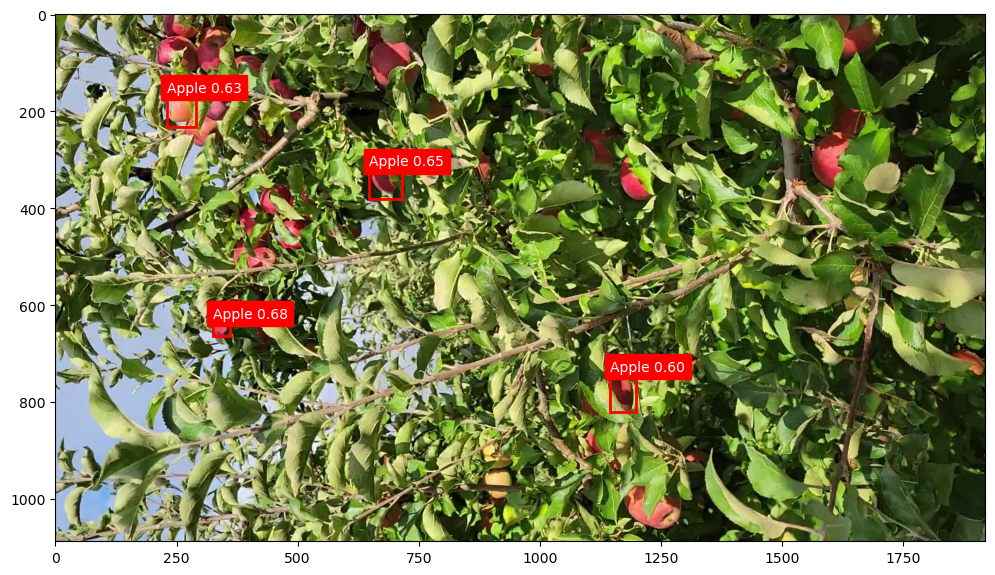

In [5]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

for box, score, label in zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels']):
    if score > 0.5:  # confidence threshold
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                                 edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f"Apple {score:.2f}", color='white', backgroundcolor='red')

plt.show()


In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image

# Load one test image
img_path = "apple-detection/test/app00121_jpeg.rf.028cea0513e2420f5a00312005f13825.jpg"  # change to your test image path
img = Image.open(img_path).convert("RGB")

# Transform to tensor
transform = T.ToTensor()
img_tensor = transform(img).to(device)

# Run inference (no targets during inference!)
with torch.no_grad():
    prediction = model([img_tensor])

print(prediction)  # bounding boxes, labels, scores


[{'boxes': tensor([[4.3268e+02, 7.5874e+01, 4.6844e+02, 1.1027e+02],
        [2.5682e+02, 5.1465e+02, 3.2173e+02, 5.7437e+02],
        [1.8462e+03, 1.9979e+02, 1.9143e+03, 2.5527e+02],
        [1.3969e+03, 3.2368e+02, 1.4727e+03, 3.9085e+02],
        [1.0637e+03, 6.7846e+02, 1.1307e+03, 7.5325e+02],
        [5.0062e+02, 7.1838e+02, 5.8050e+02, 8.0306e+02],
        [4.1483e+02, 9.0429e+02, 4.9897e+02, 9.8664e+02],
        [1.7814e+03, 6.6315e+02, 1.8462e+03, 7.1984e+02],
        [5.3445e+02, 1.3516e+02, 5.7039e+02, 1.7223e+02],
        [8.0682e+02, 6.7379e+02, 8.8790e+02, 7.5026e+02],
        [1.0731e+03, 4.8212e+02, 1.1459e+03, 5.4340e+02],
        [7.3952e+02, 2.6133e+02, 7.7519e+02, 2.9833e+02],
        [4.7884e+02, 1.0670e+02, 5.1322e+02, 1.4146e+02],
        [1.7747e+03, 2.7097e+02, 1.8179e+03, 3.1449e+02],
        [5.7127e+02, 4.0603e+01, 6.1644e+02, 8.4685e+01],
        [4.6749e+02, 1.9424e+02, 5.0340e+02, 2.2859e+02],
        [2.3191e+02, 8.0978e+02, 3.2564e+02, 8.9934e+02],
   

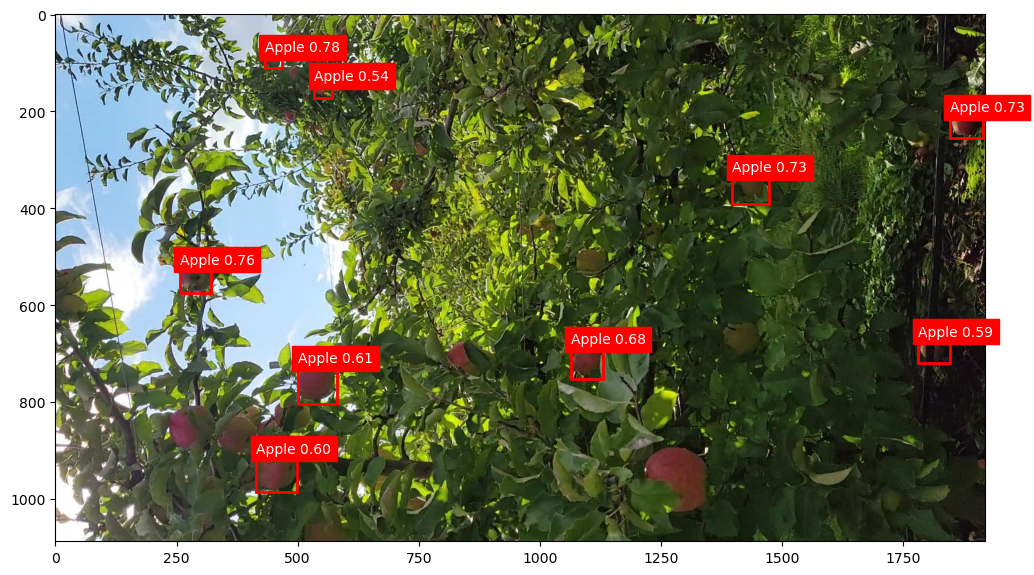

In [7]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

for box, score, label in zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels']):
    if score > 0.5:  # confidence threshold
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                                 edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f"Apple {score:.2f}", color='white', backgroundcolor='red')

plt.show()
